In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer

In [2]:
#Load the dataset
df = pd.read_csv("Bank Customer Churn Prediction.csv")

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
#Check for duplicates
df.duplicated().sum()

0

In [7]:
#Check for null rows
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [8]:
corr_cols = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']

In [9]:
#Check correlation
df[corr_cols].corr()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
products_number,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
credit_card,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
active_member,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
churn,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


DATA EXPLORATION

In [10]:
# Ensure 'churn' is treated as a categorical for plotting, but as an integer for correlation
df['churn_categorical'] = df['churn'].map({0: 'No Churn', 1: 'Churn'})

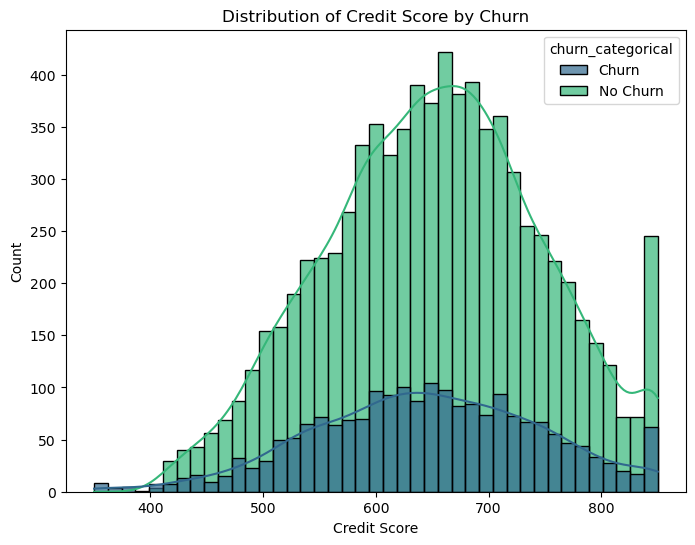

In [11]:
#Distribution of Numerical Features
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='credit_score', kde=True, hue='churn_categorical', palette='viridis', alpha=0.7)
plt.title('Distribution of Credit Score by Churn')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.show()

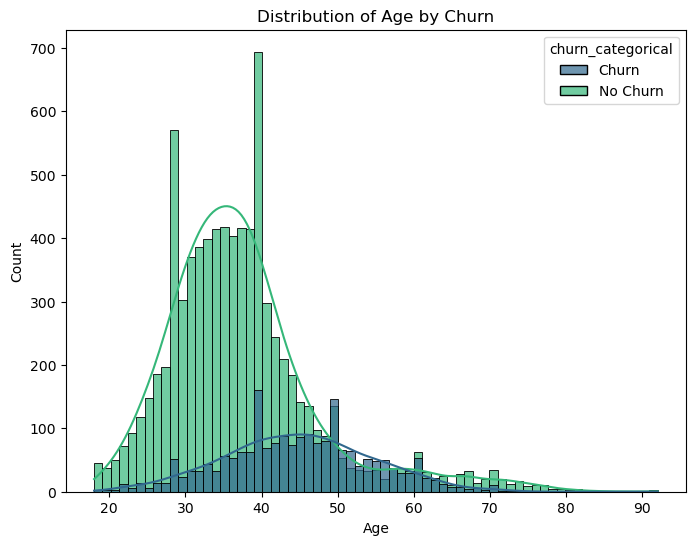

In [12]:
#Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='age', kde=True, hue='churn_categorical', palette='viridis', alpha=0.7)
plt.title('Distribution of Age by Churn')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

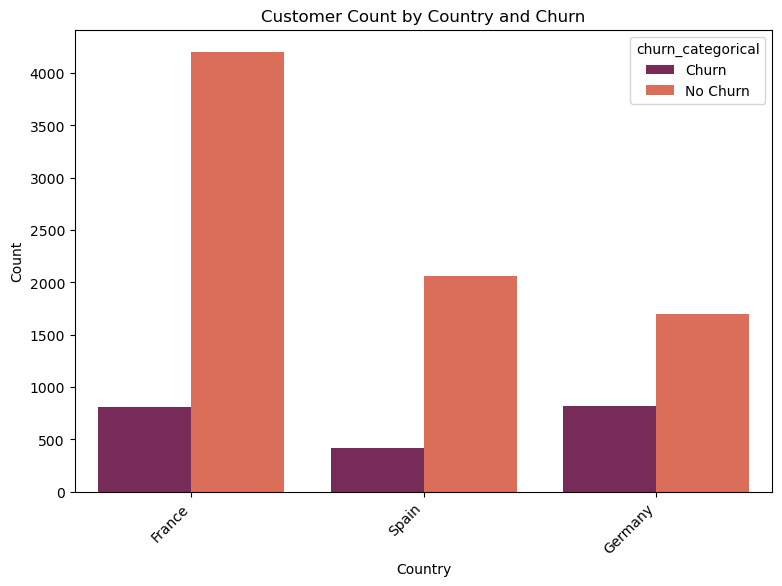

In [13]:
#Country distribution by churn
plt.figure(figsize=(9, 6))
sns.countplot(data=df, x='country', hue='churn_categorical', palette='rocket')
plt.title('Customer Count by Country and Churn')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

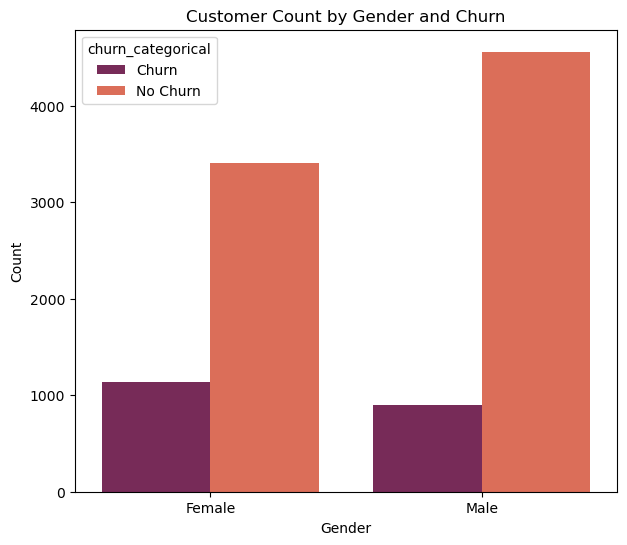

In [14]:
#Gender distribution by churn
plt.figure(figsize=(7, 6))
sns.countplot(data=df, x='gender', hue='churn_categorical', palette='rocket')
plt.title('Customer Count by Gender and Churn')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

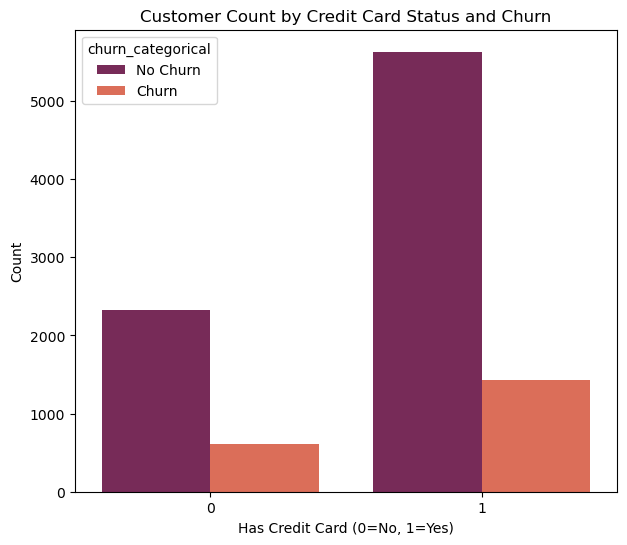

In [15]:
#Credit card  status by churn
plt.figure(figsize=(7, 6))
sns.countplot(data=df, x='credit_card', hue='churn_categorical', palette='rocket')
plt.title('Customer Count by Credit Card Status and Churn')
plt.xlabel('Has Credit Card (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

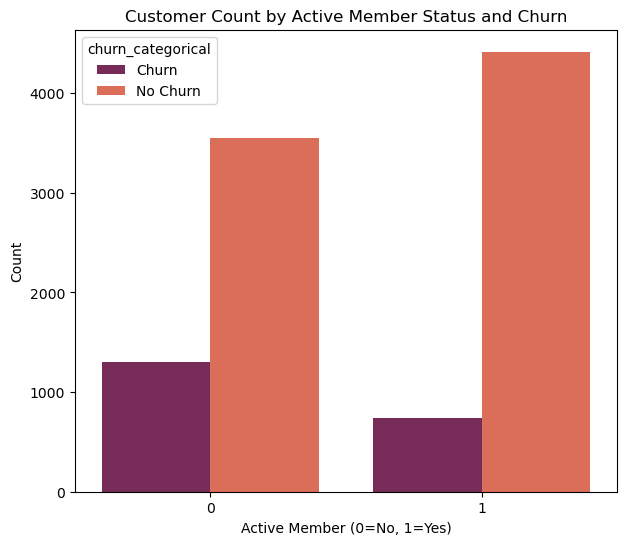

In [16]:
#Active member status by churn
plt.figure(figsize=(7, 6))
sns.countplot(data=df, x='active_member', hue='churn_categorical', palette='rocket')
plt.title('Customer Count by Active Member Status and Churn')
plt.xlabel('Active Member (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

/var/folders/p7/d9_mnjys5ss5hl9mmyf2hsgr0000gn/T/ipykernel_16640/3570352398.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='churn_categorical', palette='viridis')


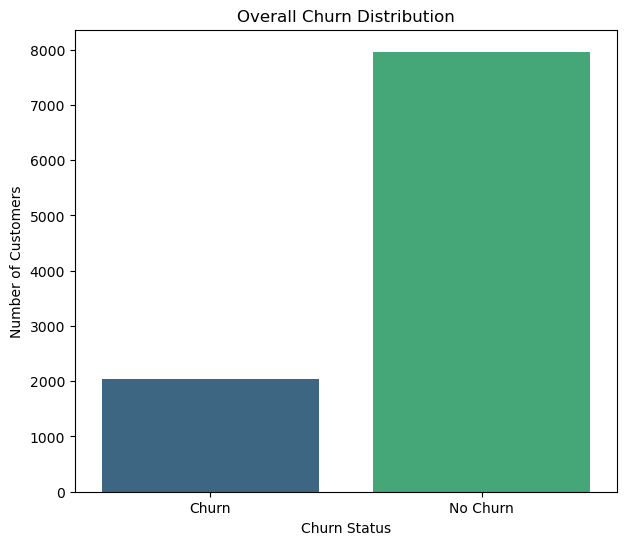

In [17]:
#Class Imbalance
plt.figure(figsize=(7, 6))
sns.countplot(data=df, x='churn_categorical', palette='viridis')
plt.title('Overall Churn Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()

In [18]:
#Split into feature and target
X = df.drop(columns=['churn', 'churn_categorical', 'customer_id'], axis=1)
y = df['churn']

In [19]:
#Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [20]:
cat_columns = list(X.select_dtypes(['object', 'category']).columns) 

In [21]:
num_columns = list(X.select_dtypes(['int64', 'float64']).columns)

In [22]:
#Using a pipeline to work on the categorical features 
cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
]) 

In [23]:
#Using a pipeline to work on the numerical features
num_pipeline = Pipeline([
    ("ss", StandardScaler())
])

In [24]:
preprocessor = ColumnTransformer(transformers=[("num", num_pipeline, num_columns),
                                              ("cat", cat_pipeline, cat_columns)])

In [25]:
#Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

In [26]:
#Random forest classifier pipeline
pipeline_rfc = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE()),
    ("rfc", RandomForestClassifier(random_state=30))
])

In [27]:
#Random forest classifier parameters
params_rfc = {
    'rfc__n_estimators': [100, 200, 300], 
    'rfc__max_depth': [None, 10, 20],     
    'rfc__min_samples_split': [2, 5],     
    'rfc__min_samples_leaf': [1, 2],       
    'rfc__criterion': ['gini']
}

In [28]:
#Hyper-parameter tuning
model_rfc = GridSearchCV(
    pipeline_rfc,
    param_grid = params_rfc,
    cv = cv,
    n_jobs = 5,
    verbose = 1
)

In [29]:
#Train the random forest model
model_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['credit_score',
                                                                          'age',
                                                                          'tenure',
                                                                          'balance',
                                                                          'products_number',
                                                                          'credit_card',
                                                                          'active_member',
                                                                          'estimated_salary']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['country',
                                                                          'gender'])])),
                                       ('smote', SMOTE()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=30))]),
             n_jobs=5,
             param_grid={'rfc__criterion': ['gini'],
                         'rfc__max_depth': [None, 10, 20],
                         'rfc__min_samples_leaf': [1, 2],
                         'rfc__min_samples_split': [2, 5],
                         'rfc__n_estimators': [100, 200, 300]},
             verbose=1)

In [30]:
model_rfc.score(X_train, y_train)

0.988875

In [31]:
y_pred_rfc = model_rfc.predict(X_test)

In [32]:
#Random forest classification report
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1564
           1       0.66      0.60      0.63       436

    accuracy                           0.84      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



In [33]:
#Random forest confusion matrix
print(confusion_matrix(y_test, y_pred_rfc))

[[1429  135]
 [ 176  260]]


In [37]:
#Best Random forest classier
best_rfc_model = model_rfc.best_estimator_
preprocessor_transformer = best_rfc_model.named_steps['preprocessor']

In [38]:
rfc_estimator = best_rfc_model.named_steps['rfc']
importances_rfc = rfc_estimator.feature_importances_
transformed_feature_names = preprocessor_transformer.get_feature_names_out()
feat_importance_rfc = pd.Series(importances_rfc, index=transformed_feature_names).sort_values()

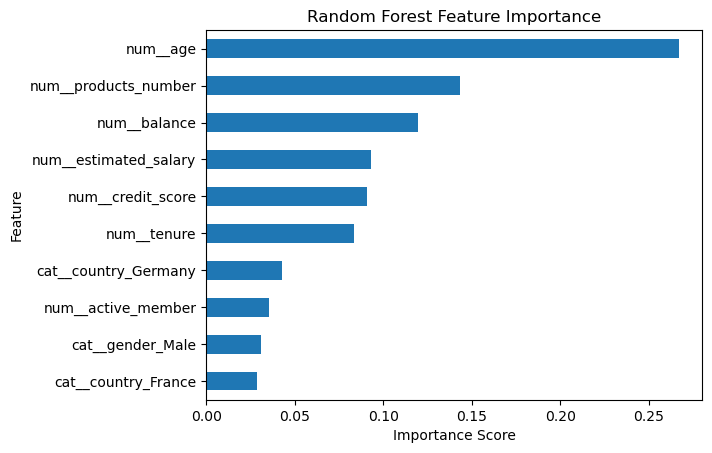

In [39]:
#Plotting the random forst classifier feature importance
feat_importance_rfc.tail(10).plot(kind='barh')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

In [40]:
# Catboost Classifier Model Pipeline
pipeline_cb = Pipeline([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=30)),
    ("cb", CatBoostClassifier(random_state=30))
])

In [41]:
#Catboost parameter
params_cb = {
    'cb__iterations': [100],
    'cb__learning_rate': [0.1],
    'cb__depth': [6],
    'cb__grow_policy': ['SymmetricTree'],
    'cb__loss_function': ['Logloss']
}

In [42]:
#Catboost Hyper-parameter tuning
model_cb = GridSearchCV(
    pipeline_cb,
    param_grid=params_cb,
    cv=cv,
    n_jobs=1,
    verbose=1
)

In [43]:
# Training the Catboost Classifier model
model_cb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.6593993	total: 69.8ms	remaining: 6.91s
1:	learn: 0.6315730	total: 73ms	remaining: 3.58s
2:	learn: 0.6110810	total: 76ms	remaining: 2.46s
3:	learn: 0.5935965	total: 79.9ms	remaining: 1.92s
4:	learn: 0.5737529	total: 83ms	remaining: 1.58s
5:	learn: 0.5569831	total: 86.5ms	remaining: 1.35s
6:	learn: 0.5416098	total: 89.6ms	remaining: 1.19s
7:	learn: 0.5287322	total: 93.7ms	remaining: 1.08s
8:	learn: 0.5168686	total: 97.2ms	remaining: 983ms
9:	learn: 0.5068372	total: 100ms	remaining: 903ms
10:	learn: 0.4980212	total: 104ms	remaining: 839ms
11:	learn: 0.4889459	total: 107ms	remaining: 784ms
12:	learn: 0.4817014	total: 110ms	remaining: 739ms
13:	learn: 0.4754406	total: 115ms	remaining: 704ms
14:	learn: 0.4687773	total: 118ms	remaining: 669ms
15:	learn: 0.4627466	total: 121ms	remaining: 634ms
16:	learn: 0.4582994	total: 124ms	remaining: 604ms
17:	learn: 0.4536098	total: 127ms	remaining: 577ms
18:	learn: 0.4488852	total: 12

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['credit_score',
                                                                          'age',
                                                                          'tenure',
                                                                          'balance',
                                                                          'products_number',
                                                                          'credit_card',
                                                                          'active_member',
                                                                          'estimated_salary']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['country',
                                                                          'gender'])])),
                                       ('smote', SMOTE(random_state=30)),
                                       ('cb',
                                        <catboost.core.CatBoostClassifier object at 0x13f5e71c0>)]),
             n_jobs=1,
             param_grid={'cb__depth': [6], 'cb__grow_policy': ['SymmetricTree'],
                         'cb__iterations': [100], 'cb__learning_rate': [0.1],
                         'cb__loss_function': ['Logloss']},
             verbose=1)

In [44]:
model_cb.score(X_train, y_train)

0.844

In [45]:
y_pred_cb = model_cb.predict(X_test)

In [46]:
# Catboost Classifier model classification report
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1564
           1       0.63      0.67      0.65       436

    accuracy                           0.84      2000
   macro avg       0.77      0.78      0.78      2000
weighted avg       0.85      0.84      0.85      2000



In [47]:
# Catboost Classifier model confusion matrix
print(confusion_matrix(y_test, y_pred_cb))

[[1395  169]
 [ 144  292]]


In [59]:
# Best Catboost Classier
best_cb_model = model_cb.best_estimator_
preprocessor_transformer_cb = best_cb_model.named_steps['preprocessor']

In [60]:
cb_estimator = best_cb_model.named_steps['cb']
importances_cb = cb_estimator.feature_importances_
transformed_feature_names_cb = preprocessor_transformer_cb.get_feature_names_out()
feat_importance_cb = pd.Series(importances_cb, index=transformed_feature_names_cb).sort_values()

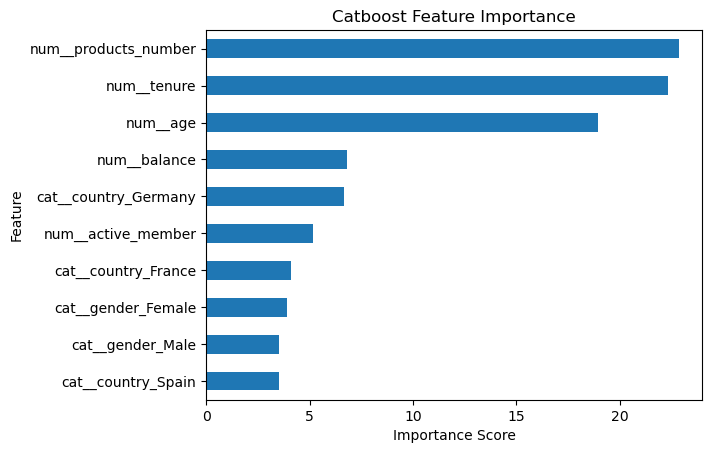

In [61]:
#Plotting the Catboost Classifier feature importance
feat_importance_cb.tail(10).plot(kind='barh')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Catboost Feature Importance")
plt.show()

In [51]:
# XGB Classifier Model Pipeline
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=30)),
    ("xgb", XGBClassifier(random_state=30))
])

In [52]:
# XGB Classifier Model Hperparamters
params_xgb = {
    'xgb__max_depth': [3, 5],
    'xgb__n_estimators': [20, 40],
    'xgb__learning_rate': [0.1],
    'xgb__tree_method': ['hist'],
    'xgb__n_jobs': [-1]
}

In [53]:
# XGB Classifier Hyperparameter tuning
model_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=params_xgb,
    cv=cv,
    n_jobs=5,
    verbose=1
)

In [54]:
# Training the XGB Classifier model
model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['credit_score',
                                                                          'age',
                                                                          'tenure',
                                                                          'balance',
                                                                          'products_number',
                                                                          'credit_card',
                                                                          'active_member',
                                                                          'estimated_salary']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=5,
             param_grid={'xgb__learning_rate': [0.1], 'xgb__max_depth': [3, 5],
                         'xgb__n_estimators': [20, 40], 'xgb__n_jobs': [-1],
                         'xgb__tree_method': ['hist']},
             verbose=1)

In [55]:
model_xgb.score(X_train, y_train)

0.836625

In [56]:
y_pred_xgb = model_xgb.predict(X_test)

In [57]:
# XGB Classifier model classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1564
           1       0.59      0.68      0.63       436

    accuracy                           0.83      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.83      0.83      2000



In [58]:
# XGB Classifier model confusion matrix
print(confusion_matrix(y_test, y_pred_xgb))

[[1362  202]
 [ 140  296]]


In [62]:
# Best XGB Classier
best_xgb_model = model_xgb.best_estimator_
preprocessor_transformer_xgb = best_xgb_model.named_steps['preprocessor']

In [64]:
xgb_estimator = best_xgb_model.named_steps['xgb']
importances_xgb = xgb_estimator.feature_importances_
transformed_feature_names_xgb = preprocessor_transformer_xgb.get_feature_names_out()
feat_importance_xgb = pd.Series(importances_xgb, index=transformed_feature_names_xgb).sort_values()

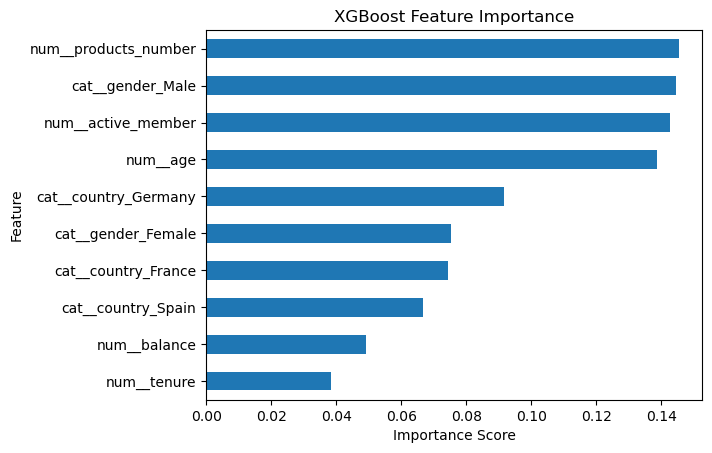

In [65]:
#Plotting the XGB Classifier feature importance
feat_importance_xgb.tail(10).plot(kind='barh')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

In [66]:
import joblib

In [67]:
joblib.dump(best_rfc_model, "banking_churn_rfc.pkl")

['banking_churn_rfc.pkl']